# Plotting

**GOAL:** 
The primary goal of the file is to illustrate and compare different approaches to plotting gridded sea surface temperature (SST) data from model simulations and satellite observations. The code demonstrates both static (matplotlib, cartopy) and interactive (hvplot) plotting methods, including how to handle geospatial masking, grid interpolation, and the visualization of model-observation differences on maps.

---

## Imports

In [1]:
import xarray as xr
import regionmask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import griddata
import hvplot.xarray

## Data

In [2]:
# --- Observations ---

# Load monthly mean sea surface temperature (SST) observations from NetCDF file.
observations = xr.open_dataset('../../data/obs/sst.mnmean.nc')

# Extract longitude and latitude arrays for later reference.
obs_lon = observations.lon.values
obs_lat = observations.lat.values

# Select SST data within the time range 2011–2022 (inclusive).
observations = observations.sst.sel(time=slice("2011", "2022"))

# Compute the monthly climatology by averaging over each calendar month for the selected years.
observations = observations.groupby('time.month').mean(dim='time')

# Create a land mask for the SST grid using regionmask's Natural Earth v5.0.0 "land_110" definition.
land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(observations)

# Generate an ocean mask: True where land_mask is NaN (i.e., ocean), False where it is land.
ocean_mask = land_mask.isnull()

# Apply the ocean mask to the SST observations, setting land grid points to NaN.
observations = observations.where(ocean_mask)

# --- Mesh ---

# Load the model mesh configuration (ORCA grid) from NetCDF file.
mesh = xr.open_dataset('../../data/model/orca05l75_domain_cfg_nemov5_10m.nc')

# Extract the 2D longitude and latitude arrays for the model's "T" grid points.
lonf = mesh['glamf'].values
latf = mesh['gphif'].values

# --- Model ---

# Load model sea surface temperature (tos) output for the period Jan 2010–Dec 2022.
model = xr.open_dataset('../../data/model/nemo00_1m_201001_202212_grid_T.nc')

# Select model SST for the time range 2011–2022 (matching the observations).
model = model.tos.sel(time_counter=slice("2011", "2022"))

# Compute model monthly climatology by averaging over each calendar month in the selected period.
model = model.groupby('time_counter.month').mean(dim='time_counter')

## Plot

### Pcolormesh

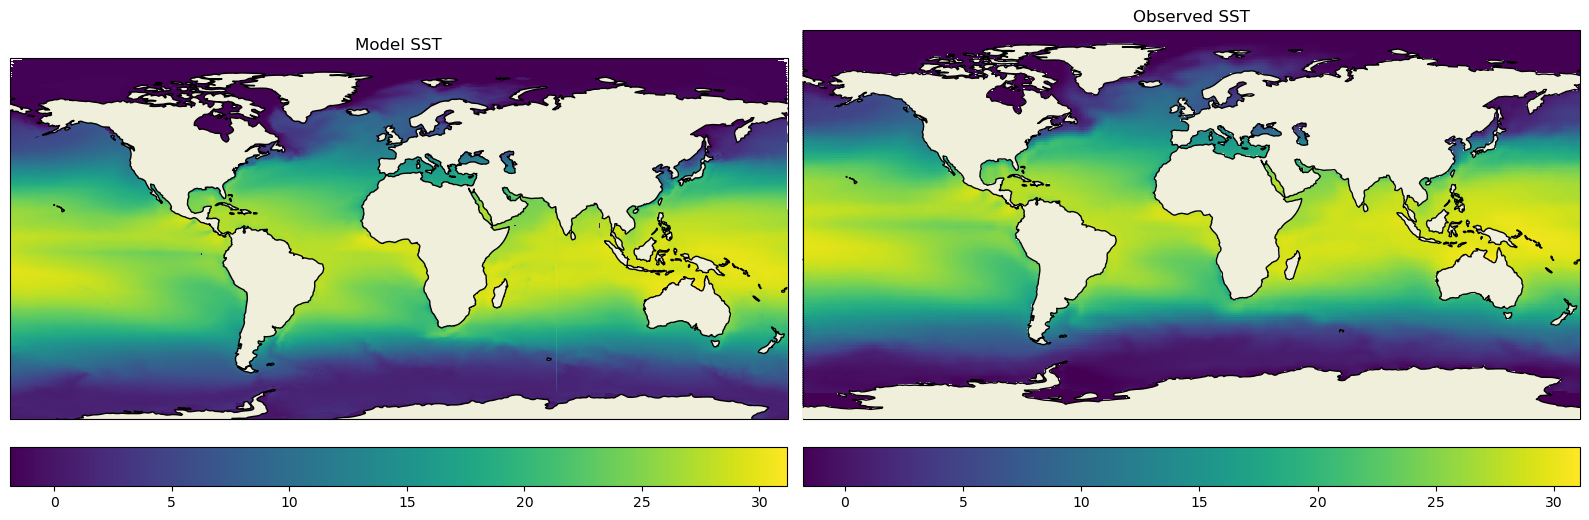

In [3]:
# --- Take one time slice ---

# Extract the first monthly mean (time index 0) as 2D arrays from model and observation climatologies.
sst_model_2d = model.values[0, :, :]       # Model SST [lat, lon] for first month (e.g., January)
sst_obs_2d = observations.values[0, :, :]  # Observational SST [lat, lon] for first month

# --- Plot setup ---

# Create a figure with two side-by-side subplots, each using PlateCarree projection for map plotting.
fig, axes = plt.subplots(ncols=2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# --- Model Plot ---
ax = axes[0]
# Plot model SST using pcolormesh; skip first row/column to match grid shape if needed.
cs = ax.pcolormesh(lonf, latf, sst_model_2d[1:,1:], transform=ccrs.PlateCarree(), shading='flat')
ax.set_title("Model SST")
# Add land and coastline features for better map context.
ax.add_feature(cfeature.LAND, zorder=50)
ax.add_feature(cfeature.COASTLINE, zorder=51)
# Add horizontal colorbar below the plot.
fig.colorbar(cs, ax=ax, orientation='horizontal', pad=0.05)

# --- Observation Plot ---
ax = axes[1]
# Plot observed SST using pcolormesh on the second subplot.
cs = ax.pcolormesh(obs_lon, obs_lat, sst_obs_2d, transform=ccrs.PlateCarree())
ax.set_title("Observed SST")
# Add land and coastline features for context.
ax.add_feature(cfeature.LAND, zorder=50)
ax.add_feature(cfeature.COASTLINE, zorder=51)
# Add horizontal colorbar below the plot.
fig.colorbar(cs, ax=ax, orientation='horizontal', pad=0.05)

# Adjust subplot layout to minimize overlap and improve appearance.
plt.tight_layout()

### Hvplot

In [4]:
# --- Plot model SST ---

# Create an interactive image plot of model monthly SST climatology.
# Uses 'x' and 'y' as spatial coordinates, 'jet' colormap, and color limits between 0°C and 30°C.
plot_model = model.isel(month=slice(0, 13)).hvplot.image(
    x='x', y='y', cmap='jet', clim=(0, 30), title='Model SST', frame_width=400)

# --- Plot observation SST ---

# Create an interactive image plot of observed monthly SST climatology.
# Uses 'lon' and 'lat' as spatial coordinates, same colormap and limits as above.
plot_obs = observations.isel(month=slice(0, 13)).hvplot.image(
    x='lon', y='lat', cmap='jet', clim=(0, 30), title='Observed SST', frame_width=400)

# --- Combine side by side ---

# Combine side by side (one row)
(plot_model + plot_obs).cols(2)

:Layout
   .DynamicMap.I  :DynamicMap   [month]
      :Image   [x,y]   (sea_surface_temperature)
   .DynamicMap.II :DynamicMap   [month]
      :Image   [lon,lat]   (Monthly Mean of Sea Surface Temperature)

### Interpolation with SciPy

In [6]:
# --- Select time index to compare ---

time_idx = 7  # Month index to compare (e.g., July)

# --- Convert model longitudes from [-180, 180] to [0, 360) ---

# Adjust model longitude values for consistency with observation grid.
model_lon_360 = (model.nav_lon.values + 360) % 360

# --- Flatten model grid and extract SST values ---

# Prepare flattened arrays of model (lon, lat) points and corresponding SST values for interpolation.
points = np.column_stack((model_lon_360.flatten(), model.nav_lat.values.flatten()))
values = model.sel(month=time_idx).values.flatten()

# --- Generate meshgrid for observation coordinates ---

# Create 2D grid of observation longitudes and latitudes for interpolation target.
obs_lon, obs_lat = np.meshgrid(observations.lon.values, observations.lat.values)

# --- Interpolate model SST onto observation grid ---

# Interpolate model SST values onto observation grid using linear interpolation.
model_interp = griddata(points, values, (obs_lon, obs_lat), method='linear')

# --- Compute SST error on observation grid ---

# Calculate the difference (error) between interpolated model SST and observed SST at selected month.
error = model_interp - observations.isel(month=time_idx).values

# --- Wrap error in xarray for convenient plotting ---

# Create an xarray DataArray for the error field with correct coordinates and dimensions.
error_xr = xr.DataArray(
    error,
    dims=('lat', 'lon'),
    coords={'lat': observations.lat, 'lon': observations.lon},
    name='SST_Error'
)

# --- Plot the error map ---

# Create an interactive error map for visualizing model-observation SST differences.
error_xr.hvplot.image(
    x='lon', y='lat',
    cmap='RdBu_r',
    clim=(-5, 5),
    title='SST Error (Model - Observation)',
    frame_width=600
)

:Image   [lon,lat]   (SST_Error)